# U-Net Train

This notebook trains a U-Net model for enhanced JPEG reconstruction.

Details:
- No residual connection
- No data augmentation
- JPEG quality varying between 5-15
- Dropout

In [1]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import StringIO
from PIL import Image
import sys
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Importing our U-Net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
from models import unet

/home/roberto/Documents/virtualenv/venv04/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Train and validation data paths
train_path = "/media/roberto/DATA/GDrive/MR-Data/JPEG-compression/tiff/Train/*.tif"
val_path = "/media/roberto/DATA/GDrive/MR-Data/JPEG-compression/tiff/Val/*.tif"

# Listing train and validation images
train_images = glob.glob(train_path)
val_images = glob.glob(val_path)

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))

Train set size: 5520
Validation set size: 2130


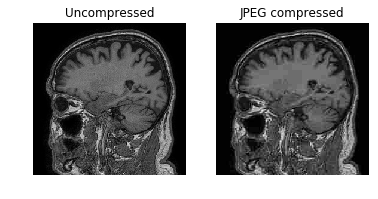

In [3]:
# Load uncompressed image
im1 = Image.open(train_images[100])
im1_array = np.array(im1)

# JPEG compress the image    
buffer = StringIO.StringIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure()
plt.subplot(121)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(122)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [4]:
H,W = 256, 256
norm = 255.0
compr_range = (5,20)

train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)
train_compr = train_unc.copy()
compr_train = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(train_images),replace = True)


# Train set
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1)

    # JPEG compress the image    
    buffer = StringIO.StringIO()
    im1.save(buffer, "JPEG", quality=compr_train[ii])
    im2 = Image.open(buffer)
    train_compr[ii,:,:,0] = np.array(im2)
    
train_unc /= norm
train_compr /= norm

# Validation set
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
val_compr = val_unc.copy()
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1)

    # JPEG compress the image    
    buffer = StringIO.StringIO()
    im1.save(buffer, "JPEG", quality=compr_train[ii])
    im2 = Image.open(buffer)
    val_compr[ii,:,:,0] = np.array(im2)
    
val_unc /= norm
val_compr /= norm

Train set


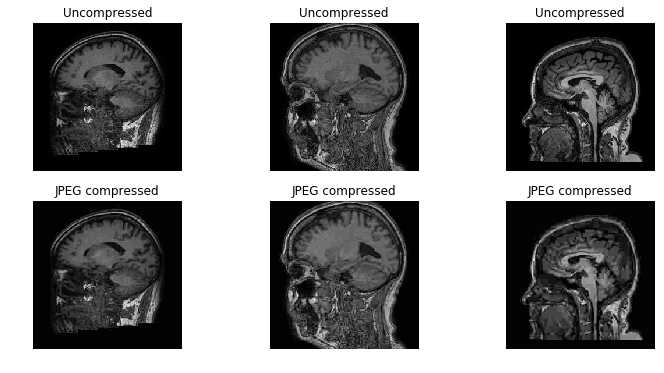

Validation set


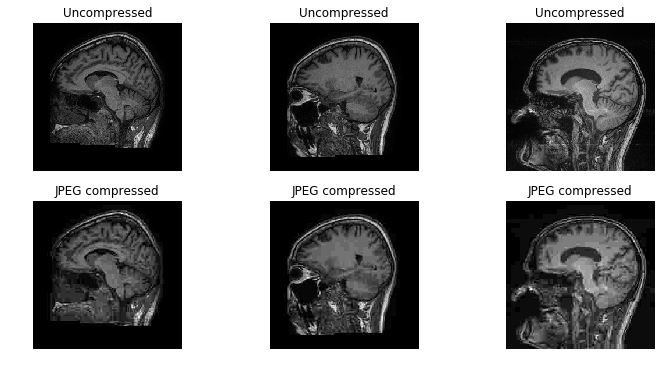

In [5]:
indexes_train = np.arange(len(train_images),dtype = int)
np.random.shuffle(indexes_train)
indexes_train = indexes_train[:3]

print("Train set")
plt.figure(figsize = (12,6))
for ii in range(3):
    plt.subplot(2,3,ii+1)
    plt.imshow(train_unc[indexes_train[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed")
    plt.subplot(2,3,ii + 4)
    plt.imshow(train_compr[indexes_train[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("JPEG compressed")
plt.show()    


indexes_val = np.arange(len(val_images),dtype = int)
np.random.shuffle(indexes_val)
indexes_val = indexes_val[:3]

print("Validation set")
plt.figure(figsize = (12,6))
for ii in range(3):
    plt.subplot(2,3,ii+1)
    plt.imshow(val_unc[indexes_val[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed")
    plt.subplot(2,3,ii + 4)
    plt.imshow(val_compr[indexes_val[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("JPEG compressed")
plt.show()    


In [6]:
epochs = 100
batch_size= 8
model_name = "../Models/unet_compress_5_15.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam()
model = unet(input_size = (256 ,256 ,1),drop = 0.0,residual = False)
model.compile(loss = "mse",optimizer=opt)

../Modules/models.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`
  model = Model(inputs = inputs, output = out)


In [7]:
hist = model.fit(train_compr,train_unc,epochs=epochs, batch_size=batch_size, verbose=1, \
                 validation_data=(val_compr,val_unc),\
                callbacks = [checkpoint,earlyStopping])

Train on 5520 samples, validate on 2130 samples
Epoch 1/100
5520/5520 [==============================] - 407s 74ms/step - loss: 0.0237 - val_loss: 0.0149
Epoch 2/100
5520/5520 [==============================] - 404s 73ms/step - loss: 0.0218 - val_loss: 0.0157
Epoch 3/100
5520/5520 [==============================] - 408s 74ms/step - loss: 0.0219 - val_loss: 0.0149
Epoch 4/100
5520/5520 [==============================] - 422s 76ms/step - loss: 0.0219 - val_loss: 0.0151
Epoch 5/100
5520/5520 [==============================] - 424s 77ms/step - loss: 0.0219 - val_loss: 0.0153
Epoch 6/100
5520/5520 [==============================] - 427s 77ms/step - loss: 0.0219 - val_loss: 0.0155
Epoch 7/100
5520/5520 [==============================] - 430s 78ms/step - loss: 0.0219 - val_loss: 0.0154
Epoch 8/100
5520/5520 [==============================] - 433s 78ms/step - loss: 0.0218 - val_loss: 0.0151
Epoch 9/100
5520/5520 [==============================] - 434s 79ms/step - loss: 0.0219 - val_loss: 0.015

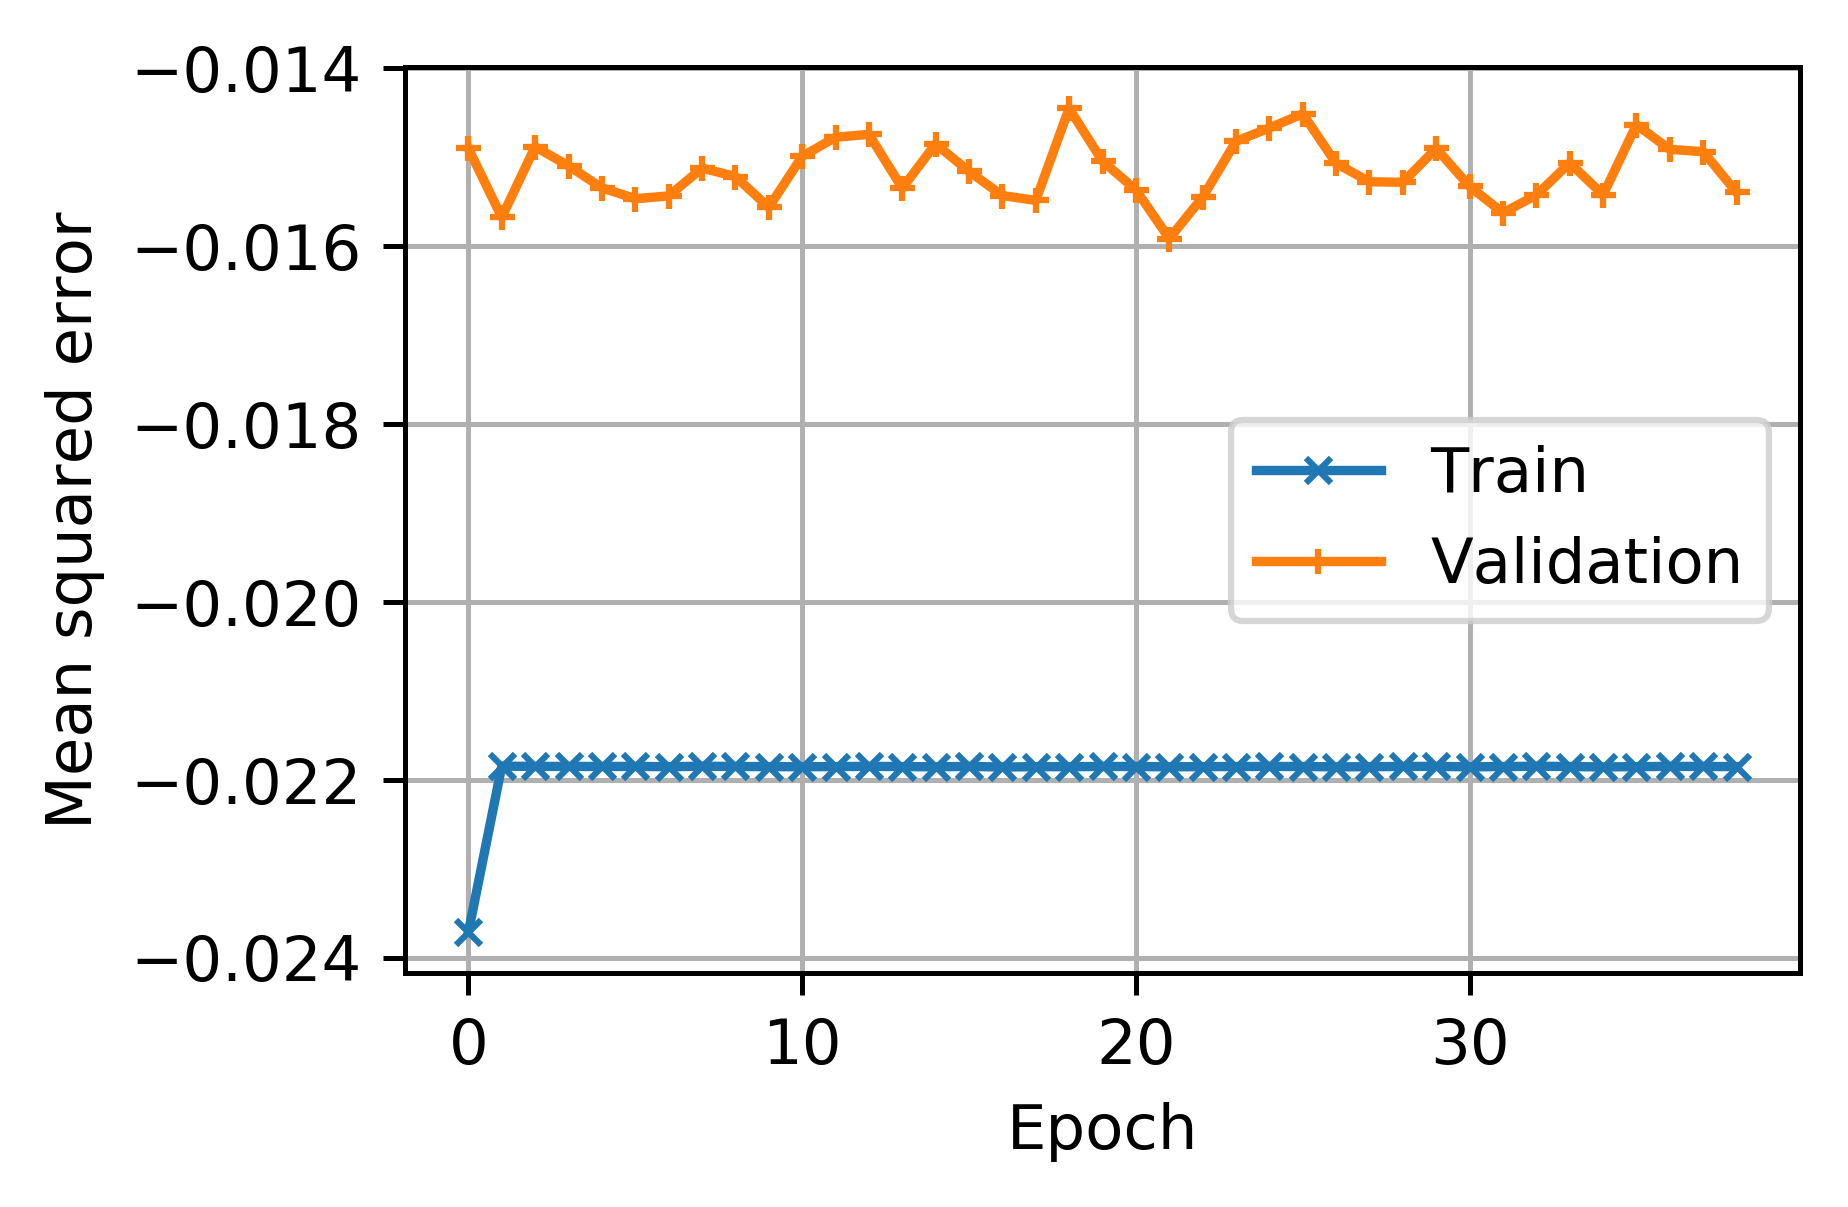

In [10]:
#Saving training history
np.save("../Data/loss_unet_compress_5_15.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_unet_compress_5_15.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(-1*loss,'x-', markersize = 4,label = "Train")
plt.plot(-1*val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()